# Billy Parmenter ~ 7526387

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns; 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC



## Flower

### Use iris flower dataset from sklearn library and try to form clusters of flowers using petal width and length features. Drop the other two features for simplicity.

In [2]:
flower_X, flower_y = load_iris(return_X_y=True, as_frame=True)
flower_X = flower_X.drop(['sepal length (cm)','sepal width (cm)'], axis=1)
flower_X

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3



#### Figure out if any preprocessing such as scaling would help here

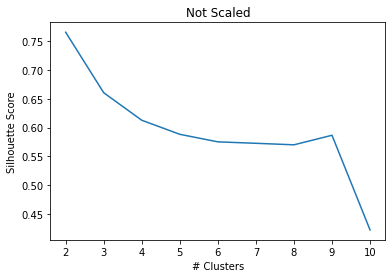

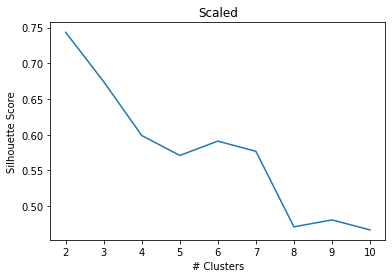

In [3]:
scaler = StandardScaler()
flower_X_scaled = scaler.fit_transform(flower_X)

def silhouette_plot(data, title):
  silhouette_scores = {}
  k_range = range(2, 11)

  for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    silhouette_scores[k] = silhouette_score(data, kmeans.labels_)

  plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
  plt.xlabel('# Clusters')
  plt.ylabel('Silhouette Score')
  plt.title(title)

  plt.show()

  return silhouette_scores


silhouette = silhouette_plot(flower_X, 'Not Scaled')
silhouette_scaled = silhouette_plot(flower_X_scaled, 'Scaled')


#### Draw elbow plot and from that figure out optimal value of k

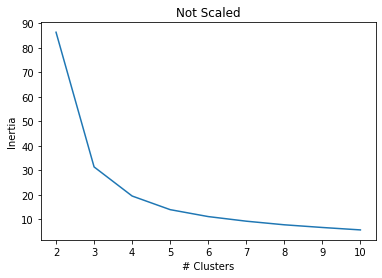

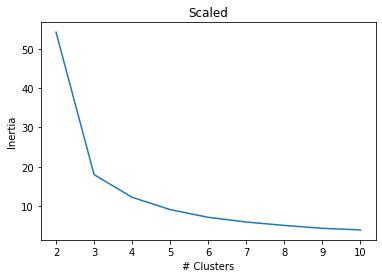

In [4]:
def elbow_plot(data, title):
    inertia_values = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    plt.plot(k_range, inertia_values)
    plt.xlabel('# Clusters')
    plt.ylabel('Inertia')
    plt.title(title)

    plt.show()

elbow_plot(flower_X, 'Not Scaled')
elbow_plot(flower_X_scaled, 'Scaled')
    

It seems like 3 clusters is the optimal. The silhouette score with k as 3 indicate that scalled is marginally better for this value of k.

## Heart

### Use the heart dataset from the Resources Folder or access it from https://www.kaggle.com/fedesoriano/heart-failure-prediction 

#### Load heart disease dataset in pandas dataframe

In [5]:
heart_csv = '../../data/heart.csv'
heart_data = pd.read_csv(heart_csv)



#### Remove outliers using Z score. Usual guideline is to remove anything that has Z score > 3 formula or Z score < -3

In [6]:
def remove_outliers_zscore(data, z_threshold=3, skip_columns=[]):
  num_removed = {}

  for column in data.columns:
    if column in skip_columns:
      continue

    mean = np.mean(data[column])
    std = np.std(data[column])
    z_scores = np.abs((data[column] - mean) / std)

    outliers = (z_scores > z_threshold) | (z_scores < -z_threshold)

    num_outliers_removed = np.sum(outliers)
    num_removed[column] = num_outliers_removed

    data = data[~outliers]

  data.reset_index(drop=True, inplace=True)

  print("Number of removed outliers:", num_removed)
  return data

def find_binary_columns(data, threshold=150):
    num_unique_values = data.nunique()

    median = np.median(num_unique_values)
    median_absolute_deviation = np.median(np.abs(num_unique_values - median))
    modified_z_scores = 0.6745 * (num_unique_values - median) / median_absolute_deviation

    return num_unique_values[modified_z_scores < threshold].index.tolist()

categorical_columns = find_binary_columns(heart_data, threshold=20)
categorical_columns.append('HeartDisease')
filtered_data = remove_outliers_zscore(heart_data, skip_columns=categorical_columns)

Number of removed outliers: {'Age': 0, 'RestingBP': 8, 'Cholesterol': 3, 'MaxHR': 1, 'Oldpeak': 7}



#### Convert text columns to numbers using label encoding / one hot encoding

In [7]:
def label_encode(data, columns_to_encode):
    encoded_data = data.copy()
    label_encoder = LabelEncoder()
    
    for column in columns_to_encode:
        encoded_data[column] = label_encoder.fit_transform(data[column])
    
    return encoded_data

encoded_data = label_encode(filtered_data, categorical_columns)
encoded_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
894,45,1,3,110,264,0,1,132,0,1.2,1,1
895,68,1,0,144,193,1,1,141,0,3.4,1,1
896,57,1,0,130,131,0,1,115,1,1.2,1,1
897,57,0,1,130,236,0,0,174,0,0.0,1,1



#### Apply scaling

In [8]:
def scale_data(data, skip_columns=[]):
    ret_data = data.copy()
    
    columns_to_scale = [col for col in ret_data.columns if col not in skip_columns]
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(ret_data[columns_to_scale])
    
    ret_data[columns_to_scale] = scaled_data
    
    return ret_data

scaled_data = scale_data(encoded_data, categorical_columns)
scaled_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.428154,1,1,0.465900,0.849636,0,1,1.384320,0,-0.855469,2,0
1,-0.475855,0,2,1.634714,-0.168122,0,1,0.752973,0,0.137516,1,1
2,-1.745588,1,1,-0.118507,0.793612,0,2,-1.535661,0,-0.855469,2,0
3,-0.581666,0,0,0.349019,0.149344,0,1,-1.141069,1,0.634008,1,1
4,0.053200,1,2,1.050307,-0.028064,0,1,-0.588640,0,-0.855469,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
894,-0.899099,1,3,-1.287320,0.616205,0,1,-0.194048,0,0.336112,1,1
895,1.534554,1,0,0.699663,-0.046738,1,1,0.161085,0,2.520678,1,1
896,0.370633,1,0,-0.118507,-0.625646,0,1,-0.864854,1,0.336112,1,1
897,0.370633,0,1,-0.118507,0.354763,0,0,1.463238,0,-0.855469,1,1



#### Build a classification model using various methods (SVM, logistic regression, random forest) and check which model gives you the best accuracy

In [14]:
def split_data(data, test_size=0.2):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  return X_train, X_test, y_train, y_test

def evaluate_model(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  
  print("Accuracy:", accuracy)

def evaluate_models(data, models):
  X_train, X_test, y_train, y_test = split_data(data)

  for model in models:
    print('\n\t~~~~\t', type(model).__name__, '\t~~~~\n')

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    evaluate_model(y_test, y_pred)

def get_pca(data, explained_threshold=0.95):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  pca = PCA()
  transformed_data = pca.fit_transform(X)

  explained_variance = np.cumsum(pca.explained_variance_ratio_)
  n_components = np.argmax(explained_variance >= explained_threshold) + 1

  pca = PCA(n_components=n_components)
  transformed_data = pca.fit_transform(X)

  transformed_df = pd.DataFrame(transformed_data, columns=[f"component_{i+1}" for i in range(n_components)])
  transformed_df['target'] = y.values

  return transformed_df

In [111]:
evaluate_models(scaled_data,
                [
                  SVC(), 
                  LogisticRegression(max_iter=1000), 
                  RandomForestClassifier()
                ])


	~~~~	 SVC 	~~~~

Accuracy: 0.8555555555555555

	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8333333333333334

	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8166666666666667


#### Now use PCA to reduce dimensions, retrain your model and see its impact on your model in terms of accuracy. 

In [93]:
heart_pca = get_pca(scaled_data)

evaluate_models(heart_pca,
                [
                  SVC(), 
                  LogisticRegression(max_iter=1000), 
                  RandomForestClassifier()
                ])


	~~~~	 SVC 	~~~~

Accuracy: 0.8388888888888889

	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8388888888888889

	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8611111111111112


It seems like PCA increased the score of the random forest classifier but reduced the accuracy of SVC.